In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

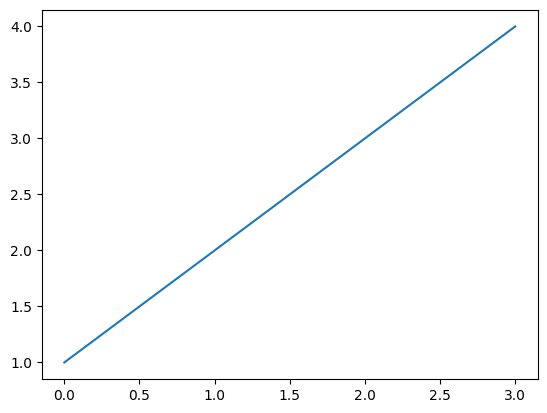

In [3]:
plt.figure()
plt.plot(np.array([1, 2, 3, 4]))
plt.show()

In [4]:
import torch
import torch.nn.functional as F
from src.Data_fetching import get_pvgis_hourly
from src.Tensors import Tensors

In [5]:
# Data fetching
latitude =52
longitude = 0
optimal_angles = 1                                                                    # 1 if azimuth and tilt are not known, otherwise 0
azimuth = None                                                                        # None if azimuth is not known
tilt = None                                                                           # None if tilt is not known
peak_power = 2.48                                                                     # The peak output of the system
loss = 14                        

In [6]:
start_date = 2005
end_date = None

parameters_PVGIS = {'lat': latitude,
              'lon': longitude,
              'startyear': start_date,
              'endyear': end_date,
              'outputformat': 'json',
              'angle': tilt,
              'aspect': azimuth,
              'optimalangles': optimal_angles,
              'pvcalculation': 1,
              'components': 1,
              'peakpower': peak_power,
              'loss': loss,
              'localtime': 0}

In [7]:
pv_data = get_pvgis_hourly(parameters_PVGIS)[['P']]

In [8]:
pv_data.index = pv_data.index.floor('h').tz_localize(None)

In [9]:
pv_data.loc[:, 'hour_sin'] = np.sin(2 * np.pi * pv_data.index.hour / 24)
pv_data.loc[:, 'hour_cos'] = np.cos(2 * np.pi * pv_data.index.hour / 24)

In [10]:
past_features = ['P']                                                                 
future_features = ['hour_sin',                                                        
                   'hour_cos']

lags = 24                                                                             
forecast_period = 24                                                                  
gap = -23
forecast_gap = -23

In [74]:
# Get the data in the torch.tensor format
target_tensors = Tensors(pv_data,
                         'P',
                         past_features ,
                         future_features,
                         lags,
                         forecast_period,
                         gap=gap,
                         forecast_gap=forecast_gap,
                         train_test_split=0.8)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train, X_test, y_train, y_test = target_tensors.create_tensor()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([112186, 24, 3]),
 torch.Size([28046, 24, 3]),
 torch.Size([112186, 24]),
 torch.Size([28046, 24]))

In [75]:
from src.DeepAR import DeepAR
from src.DeepAR import Training

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
distribution = "beta"

In [78]:
deepar = DeepAR(input_size=3,
                hidden_size=200,
                num_layers=2,
                dropout=0.5,
                distr_output=distribution
                )

In [79]:
trainer = Training(deepar,X_train,y_train, X_test, y_test, epochs=50,batch_size=64, learning_rate=0.001)

In [80]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [81]:
def _beta_nll(alpha, beta, x):
    x = x.clamp(1e-6, 1 - 1e-6)
    # Compute log-likelihood for data
    log_likelihood = ((alpha - 1) * torch.log(x) +
                      (beta - 1) * torch.log(1 - x)).sum()
    # Normalization term using log Gamma (torch.lgamma is log Gamma)
    normalization = torch.lgamma(alpha) + torch.lgamma(beta) - torch.lgamma(alpha + beta)
    # Negative log-likelihood
    nll = - (log_likelihood - x.shape[0] * normalization)
    return nll

In [82]:
batch_size=32,
learning_rate=0.001,


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = TensorDataset(X_train.to(device), y_train.to(device))
test_data = TensorDataset(X_test.to(device), y_test.to(device))
train_loader = DataLoader(train_data, batch_size=1)
test_loader = DataLoader(test_data, batch_size=1)

model = deepar.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 1

In [83]:
num_train_batches = 0
num_test_batches = 0
total_loss = 0
total_test_loss = 0

In [84]:
batches = iter(train_loader)
model.train()

DeepAR(
  (lstm): LSTM(3, 200, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=200, out_features=2, bias=True)
)

In [85]:
for input, output in batches:
    input_1 = input
    output_1 = output
    break

In [86]:
alpha, beta = model(input_1)

In [87]:
alpha

tensor([[0.6566, 0.6542, 0.6529, 0.6521, 0.6515, 0.6531, 0.6531, 0.6527, 0.6538,
         0.6495, 0.6508, 0.6522, 0.6515, 0.6513, 0.6514, 0.6509, 0.6499, 0.6482,
         0.6486, 0.6499, 0.6505, 0.6504, 0.6487, 0.6489]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [88]:
beta

tensor([[0.6953, 0.6949, 0.6955, 0.6950, 0.6935, 0.6924, 0.6908, 0.6899, 0.6915,
         0.6926, 0.6922, 0.6927, 0.6905, 0.6929, 0.6941, 0.6941, 0.6943, 0.6937,
         0.6932, 0.6922, 0.6924, 0.6906, 0.6922, 0.6908]], device='cuda:0',
       grad_fn=<AddBackward0>)

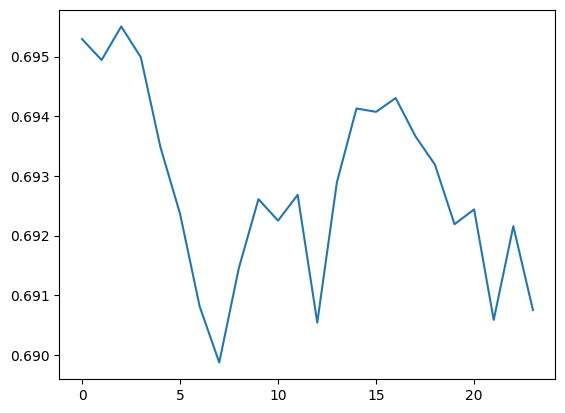

In [89]:
plt.plot(beta.cpu().detach().flatten().numpy())

In [94]:
output_1

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0021,
         0.0341, 0.0200, 0.0291, 0.0362, 0.0126, 0.0003, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')

In [95]:
alpha

tensor([[0.6566, 0.6542, 0.6529, 0.6521, 0.6515, 0.6531, 0.6531, 0.6527, 0.6538,
         0.6495, 0.6508, 0.6522, 0.6515, 0.6513, 0.6514, 0.6509, 0.6499, 0.6482,
         0.6486, 0.6499, 0.6505, 0.6504, 0.6487, 0.6489]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [93]:
beta

tensor([[0.6953, 0.6949, 0.6955, 0.6950, 0.6935, 0.6924, 0.6908, 0.6899, 0.6915,
         0.6926, 0.6922, 0.6927, 0.6905, 0.6929, 0.6941, 0.6941, 0.6943, 0.6937,
         0.6932, 0.6922, 0.6924, 0.6906, 0.6922, 0.6908]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [91]:
_beta_nll(alpha, beta, output_1)

tensor([[-92.6795, -92.6762, -92.6752, -92.6736, -92.6712, -92.6719, -92.6702,
         -92.6686, -92.6717, -92.6677, -92.6689, -92.6712, -92.6679, -92.6703,
         -92.6719, -92.6712, -92.6701, -92.6673, -92.6673, -92.6677, -92.6688,
         -92.6665, -92.6662, -92.6649]], device='cuda:0',
       grad_fn=<NegBackward0>)

Step 0: Average train loss: -12425.5137 | Average test loss: -12689.0885
Step 5: Average train loss: -12511.5553 | Average test loss: -12690.5588
Step 10: Average train loss: -12512.0558 | Average test loss: -12689.5654
Step 15: Average train loss: -12512.0440 | Average test loss: -12694.4735
Step 20: Average train loss: -12512.0076 | Average test loss: -12695.2724
Step 25: Average train loss: -12512.1803 | Average test loss: -12695.6310
Step 30: Average train loss: -12512.3891 | Average test loss: -12696.1040
Step 35: Average train loss: -12512.5843 | Average test loss: -12696.5012
Step 40: Average train loss: -12512.7065 | Average test loss: -12696.5252
Step 45: Average train loss: -12512.8106 | Average test loss: -12696.5214
Best Epoch: 46


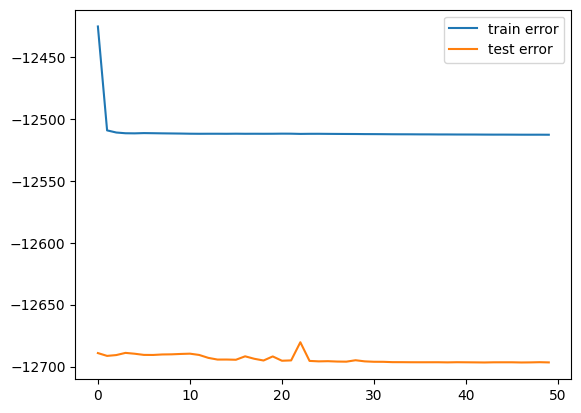

In [16]:
state_dict_list, best_epoch = trainer.fit(verbose=True)

In [17]:
deepar.load_state_dict(state_dict_list[best_epoch])

<All keys matched successfully>

In [18]:
deepar.eval()

DeepAR(
  (lstm): LSTM(3, 200, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=200, out_features=2, bias=True)
)

In [29]:
day = 100

with torch.no_grad():
    # --- PRIMING PHASE (Run Once) ---
    
    # Run history through LSTM to get the final hidden state h_t and c_t
    # (The state that summarizes the context window up to time t)
    _, (h_initial, c_initial) = deepar.lstm(X_test[14+24*day:15+24*day, :, :].to(device))
    
    # Calculate the parameters for the first prediction, t+1, based on the primed state
    last_output, _ = deepar.lstm(X_test[14+24*day:15+24*day, -1:, :].to(device), (h_initial, c_initial))
    params_t_plus_1 = deepar.linear(last_output.squeeze(0).squeeze(0))
    
    if distribution == "gaussian":
        mu_t1 = params_t_plus_1[0]
        sigma_t1 = F.softplus(params_t_plus_1[1]) + 1e-6
        
    elif distribution == "beta":
        alpha_t1 = F.softplus(params_t_plus_1[0]) + 1e-6
        beta_t1 = F.softplus(params_t_plus_1[1]) + 1e-6
    
    # Extract future exogenous features for the recursive loop
    # Shape [23, 2] (23 steps, 2 features)
    future_exog_features = X_test[15+24*day:15+24*(day+1), -1, 1:].to(device)

    # List to store all 100 scenario paths
    all_scenarios = []

    # --- SCENARIO GENERATION LOOP (Run 100 Times) ---
    NUM_SCENARIOS = 1000
    
    for s in range(NUM_SCENARIOS):
        
        # 2. Reset the Hidden State and Start the Path
        
        # IMPORTANT: CLONE the initial hidden state for each scenario
        # This ensures each scenario starts with the same memory (h_t, c_t)
        h_s, c_s = h_initial.clone(), c_initial.clone()
        
        # Sample the first value Y_{t+1} using the common mu_t1, sigma_t1
        if distribution == "guassian":
            current_sampled_value = torch.normal(mu_t1, sigma_t1, size=(1,)).to(device)
        elif distribution == "beta":
            # alpha_t1 and beta_t1 are tensors of shape matching your batch
            beta_dist = torch.distributions.Beta(alpha_t1, beta_t1)
            # Sample a single value
            current_sampled_value = beta_dist.sample().unsqueeze(-1).to(device)
            
        scenario_path = [current_sampled_value.item()]

        # 3. Recursive Prediction Loop (t+2 to t+24)
        
        for i in range(2, 25): # Loop for 23 more steps
            
            # 1. Prepare the single-step input vector [Y_{t+i-1}, Hour_{t+i}, Month_{t+i}]
            current_exog = future_exog_features[i - 2] 
            input_vector_1D = torch.cat((current_sampled_value, current_exog), dim=0) 
            lstm_input = input_vector_1D.unsqueeze(0).unsqueeze(0) # [1, 1, 3]
        
            # 2. Run the LSTM with the previous hidden state (h_s, c_s)
            # The state h_s, c_s is updated inside this call
            out, (h_s, c_s) = deepar.lstm(lstm_input, (h_s, c_s)) 
            
            # 3. Calculate parameters and sample the new value
            params = deepar.linear(out.squeeze(0).squeeze(0))
            
            if distribution == "guassian":
                mu = params[0]
                sigma = F.softplus(params[1]) + 1e-6 # Consistent with your forward
                # Sample the next PV value (new random epsilon used here!)
                current_sampled_value = torch.normal(mu, sigma, size=(1,)).to(device)
            elif distribution == "beta":
                alpha = F.softplus(params[0]) + 1e-6
                beta = F.softplus(params[1]) + 1e-6
                # alpha_t1 and beta_t1 are tensors of shape matching your batch
                beta_dist = torch.distributions.Beta(alpha, beta)
                # Sample a single value
                current_sampled_value = beta_dist.sample().unsqueeze(-1).to(device)
            
            scenario_path.append(current_sampled_value.item())

        # 4. Store the completed 24-step scenario path
        all_scenarios.append(scenario_path)

print(f"Generated {len(all_scenarios)} scenarios, each with {len(all_scenarios[0])} time steps.")

Generated 1000 scenarios, each with 24 time steps.


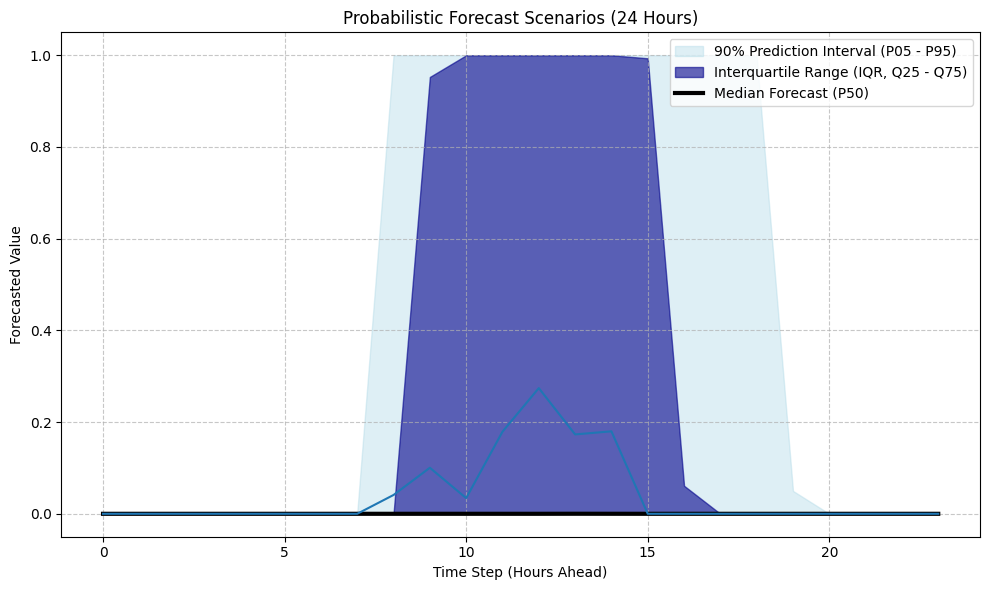

In [30]:
scenarios_array = np.array(all_scenarios)
df_scenarios = pd.DataFrame(scenarios_array).T 

# 2. Calculate the required percentiles across all scenarios for each timestep
quantiles = df_scenarios.quantile([0.05, 0.25, 0.50, 0.75, 0.95], axis=1)

# Transpose the result and rename columns for clarity
quantiles = quantiles.T
quantiles.columns = ['P05', 'Q25', 'Q50_Median', 'Q75', 'P95']

# Create the Time Step index (1 to 24)
num_steps = len(quantiles)
quantiles['Time Step'] = np.arange(0, num_steps)

# 3. Plotting the Uncertainty Bands and Median

plt.figure(figsize=(10, 6))

# a) Q10 - Q90 (Light Blue Hue)
plt.fill_between(
    quantiles['Time Step'],
    quantiles['P05'],
    quantiles['P95'],
    color='lightblue',
    alpha=0.4,
    label='90% Prediction Interval (P05 - P95)'
)

# b) IQR (P25 - P75) (Dark Blue Hue)
plt.fill_between(
    quantiles['Time Step'],
    quantiles['Q25'],
    quantiles['Q75'],
    color='darkblue',
    alpha=0.6,
    label='Interquartile Range (IQR, Q25 - Q75)'
)

# c) Median (P50) (Thick Line)
plt.plot(
    quantiles['Time Step'],
    quantiles['Q50_Median'],
    color='black',
    linewidth=3,
    label='Median Forecast (P50)'
)

plt.plot(y_test[14+24*day])


# Final Touches
plt.title('Probabilistic Forecast Scenarios (24 Hours)')
plt.xlabel('Time Step (Hours Ahead)')
plt.ylabel('Forecasted Value') # Adjust this label if you have specific units (e.g., kW, €)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show() # Display the plot